In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import geopy
import geopandas

In [2]:
orders_full = pd.read_csv('../Sales Forecasting/data/rologolf_orders.csv', header = 0, sep=',')
orders_full.describe()

,Subtotal,Shipping,Taxes,Total,Discount Amount,Lineitem quantity,Lineitem price,Lineitem compare at price,Lineitem sku,Note Attributes,...,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number
count,403.000000,403.000000,403.000000,403.000000,403.000000,630.000000,630.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.300000e+01,0.0
mean,68.264069,7.278486,0.182010,75.724566,36.173747,1.050794,64.171190,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.618236e+10,NaN
std,46.619101,4.981776,1.412362,44.799425,47.354108,0.271528,14.638838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.092908e+09,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.690000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.226751e+10,NaN
25%,35.880000,0.000000,0.000000,49.220000,10.350000,1.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.416727e+10,NaN
50%,58.650000,9.460000,0.000000,69.000000,27.600000,1.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.647279e+10,NaN
75%,71.760000,10.380000,0.000000,86.010000,50.845000,1.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.787300e+10,NaN
max,483.000000,26.720000,16.140000,483.000000,483.000000,4.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.949923e+10,NaN


In [3]:
cols = ['Name','Shipping Method','Created at','Shipping Street','Shipping Address1',
       'Shipping Address2','Shipping City','Shipping Zip','Shipping Province','Shipping Country']
orders = orders_full[cols]
orders = orders.dropna(axis='rows', subset=['Shipping Address1']).reset_index(drop=True) 

orders['Full Address'] = orders['Shipping Address1'] + ', ' + orders['Shipping City'] + ' ' + \
    orders['Shipping Province'] + ' ' + orders['Shipping Country']
orders = orders.drop(['Shipping Street', 'Shipping Address1', 'Shipping Address2',
                      'Shipping City', 'Shipping Province', 'Shipping Country'], axis=1)

orders['datetime'] = orders['Created at'].apply(lambda st: st[:19])
orders['datetime'] = pd.to_datetime(orders['datetime'], errors='coerce')
orders['datetime'] = orders['datetime'] - timedelta(hours=4) #handling timezones, UTC-4 for now
orders['Date'] = orders['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
orders = orders.drop(['Created at'], axis=1)

orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date
0,#1403,Standard,'94587,"33721 8th Street, Union City CA US",2020-11-02 21:32:21,2020-11-02
1,#1402,Expedited,M9N 2H3,"51 queens drive, Toronto ON CA",2020-10-29 12:04:16,2020-10-29
2,#1401,Free Shipping (Cart Value Over $100),L3V 3S6,"55 North St W, Orillia ON CA",2020-10-28 06:49:30,2020-10-28
3,#1400,Standard,N2L 1E6,"103 Allen Street West, Waterloo ON CA",2020-10-27 18:49:09,2020-10-27
4,#1399,Standard,N0B 2J0,"46 Carriage Lane, Puslinch ON CA",2020-10-27 18:32:55,2020-10-27


In [4]:
orders['Shipping Method'].unique()

array(['Standard', 'Expedited', 'Free Shipping (Cart Value Over $100)',
       nan, 'Small Packet International Surface',
       'Small Packet International Air'], dtype=object)

In [73]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# This is using Nominatim (OpenStreetMap) for now
# Google Maps would be ideal but requires API key
geolocator = Nominatim(user_agent="fydp")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)

#orders = orders[:50] #testing with partial df
orders['Geolocation'] = orders['Full Address'].apply(geocode)
#orders['Lat'] = orders['Geolocation'].apply(lambda loc: loc.latitude if loc else None)
#orders['Long'] = orders['Geolocation'].apply(lambda loc: loc.longitude if loc else None)
orders['Coordinates'] = orders['Geolocation'].apply(lambda loc: (loc.latitude, loc.longitude) if loc else None)

orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates
0,#1403,Standard,'94587,"33721 8th Street, Union City CA US",2020-11-02 21:32:21,2020-11-02,"(33721, 8th Street, Pabrico, Union City, Alame...","(37.59922149523446, -122.02065810832903)"
1,#1402,Expedited,M9N 2H3,"51 queens drive, Toronto ON CA",2020-10-29 12:04:16,2020-10-29,"(51, Queen's Drive, North York, Toronto, Golde...","(43.70477029313778, -79.51551360106798)"
2,#1401,Free Shipping (Cart Value Over $100),L3V 3S6,"55 North St W, Orillia ON CA",2020-10-28 06:49:30,2020-10-28,"(55, North Street West, Orillia, Central Ontar...","(44.61598007190863, -79.42998734550359)"
3,#1400,Standard,N2L 1E6,"103 Allen Street West, Waterloo ON CA",2020-10-27 18:49:09,2020-10-27,"(103, Allen Street West, Uptown, Waterloo, Reg...","(43.4560552, -80.5238058)"
4,#1399,Standard,N0B 2J0,"46 Carriage Lane, Puslinch ON CA",2020-10-27 18:32:55,2020-10-27,"(46, Carriage Lane, Puslinch, Wellington Count...","(43.477993351761285, -80.17007432464743)"


In [74]:
from geopy import distance
# Using direct distance between the two points
# TODO: driving distance using Google Maps API
hq_loc = geolocator.geocode("square one")
hq_coords = (hq_loc.latitude, hq_loc.longitude)
orders['Distance'] = orders['Coordinates'].apply(lambda x: distance.distance(hq_coords, x).km)

orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Distance
0,#1403,Standard,'94587,"33721 8th Street, Union City CA US",2020-11-02 21:32:21,2020-11-02,"(33721, 8th Street, Pabrico, Union City, Alame...","(37.59922149523446, -122.02065810832903)",3608.073482
1,#1402,Expedited,M9N 2H3,"51 queens drive, Toronto ON CA",2020-10-29 12:04:16,2020-10-29,"(51, Queen's Drive, North York, Toronto, Golde...","(43.70477029313778, -79.51551360106798)",16.167603
2,#1401,Free Shipping (Cart Value Over $100),L3V 3S6,"55 North St W, Orillia ON CA",2020-10-28 06:49:30,2020-10-28,"(55, North Street West, Orillia, Central Ontar...","(44.61598007190863, -79.42998734550359)",114.971533
3,#1400,Standard,N2L 1E6,"103 Allen Street West, Waterloo ON CA",2020-10-27 18:49:09,2020-10-27,"(103, Allen Street West, Uptown, Waterloo, Reg...","(43.4560552, -80.5238058)",72.774813
4,#1399,Standard,N0B 2J0,"46 Carriage Lane, Puslinch ON CA",2020-10-27 18:32:55,2020-10-27,"(46, Carriage Lane, Puslinch, Wellington Count...","(43.477993351761285, -80.17007432464743)",44.436445


In [75]:
# placeholder function
def calculate_emissions(method, distance):
    if method == 'Expedited':
        shipping_method_factor = 3
    else:
        shipping_method_factor = 1
    # placeholder emissions calculation
    co2 = distance*shipping_method_factor
    return co2

orders['CO2 Emissions'] = orders.apply(lambda x: calculate_emissions(x['Shipping Method'],
                                                                     x['Distance']), axis=1)
orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Distance,CO2 Emissions
0,#1403,Standard,'94587,"33721 8th Street, Union City CA US",2020-11-02 21:32:21,2020-11-02,"(33721, 8th Street, Pabrico, Union City, Alame...","(37.59922149523446, -122.02065810832903)",3608.073482,3608.073482
1,#1402,Expedited,M9N 2H3,"51 queens drive, Toronto ON CA",2020-10-29 12:04:16,2020-10-29,"(51, Queen's Drive, North York, Toronto, Golde...","(43.70477029313778, -79.51551360106798)",16.167603,48.502808
2,#1401,Free Shipping (Cart Value Over $100),L3V 3S6,"55 North St W, Orillia ON CA",2020-10-28 06:49:30,2020-10-28,"(55, North Street West, Orillia, Central Ontar...","(44.61598007190863, -79.42998734550359)",114.971533,114.971533
3,#1400,Standard,N2L 1E6,"103 Allen Street West, Waterloo ON CA",2020-10-27 18:49:09,2020-10-27,"(103, Allen Street West, Uptown, Waterloo, Reg...","(43.4560552, -80.5238058)",72.774813,72.774813
4,#1399,Standard,N0B 2J0,"46 Carriage Lane, Puslinch ON CA",2020-10-27 18:32:55,2020-10-27,"(46, Carriage Lane, Puslinch, Wellington Count...","(43.477993351761285, -80.17007432464743)",44.436445,44.436445


Text(0, 0.5, 'Emissions Total')

<Figure size 432x288 with 0 Axes>

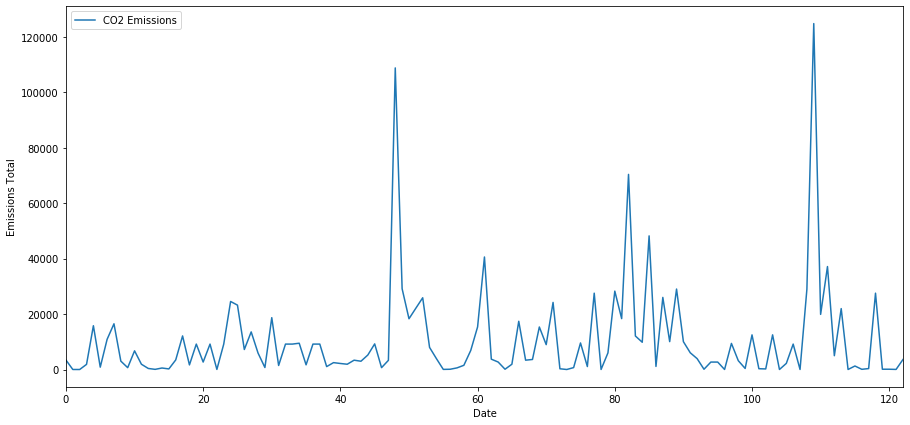

In [76]:
import matplotlib.pyplot as plt

# plotting CO2 emissions over time
plt.figure()
co2_per_day = orders.groupby(['Date'])['CO2 Emissions'].sum().reset_index()
co2_per_day.plot.line(figsize=(15,7))
plt.xlabel('Date')
plt.ylabel('Emissions Total')